In [1]:
import cv2
import mediapipe as mp
import time
import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.animation as animation
from matplotlib import style
from IPython.display import display, clear_output
from scipy.signal import filtfilt, butter, lfilter, medfilt
from matplotlib import pyplot as plt 
import math
from scipy import stats

In [2]:
import pandas as pd
df = pd.DataFrame(columns=("name", "SNR", "STD", "powerSNR", "powerSTD", "dxSNR", "dxSTD", "isReal"))
df

,name,SNR,STD,powerSNR,powerSTD,dxSNR,dxSTD,isReal


In [3]:
def polygon(image, coordinates, facial_landmarks):
    height, width, _ = image.shape

    area = []
    for i in coordinates:
        pt1 = facial_landmarks.landmark[i]
        x = int(pt1.x * width)
        y = int(pt1.y * height)
        area.append([x,y])
        #cv2.circle(image, (x, y), 2, (100, 100, 0), -1)
        #cv2.putText(image, str(i), (x, y), 0, 0.5, (0, 0, 0))
        
    area = np.array(area)
    area = area.reshape((-1, 1, 2))
    #cv2.polylines(image,[area],True,(0,255,255))
    
    return area

In [4]:
def extract_roi(image, yanak_sag , yanak_sol, alin):
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [yanak_sag], -1, (255, 255, 255), -1, cv2.LINE_AA)
    cv2.drawContours(mask, [yanak_sol], -1, (255, 255, 255), -1, cv2.LINE_AA)
    cv2.drawContours(mask, [alin], -1, (255, 255, 255), -1, cv2.LINE_AA)

    output = cv2.bitwise_and(image, image, mask=mask)
    return output

In [5]:
def green(image, area):
    mask_G = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask_G, [area], -1, (255, 255, 255), -1, cv2.LINE_AA)
    mean = cv2.mean(image[:,:,1], mask=mask_G)
    #print(f"{txt}= {mean}")
    return mean

In [6]:
def update_signal(green_mean, green_arr, n_frames, hepsi):
    
    if len(green_arr) < n_frames:
        green_arr.append(green_mean)
    else:
        del green_arr[0]
        green_arr.append(green_mean)
        
    hepsi.append(green_mean)

In [7]:
def nabiz_bul(mean_list, fps, hz_bottom, hz_top):
    sampling_rate = fps
    raw_signal = np.squeeze(mean_list) 
    normalized_signal = raw_signal - np.mean(raw_signal)
    normalized_signal = normalized_signal / np.std(normalized_signal)
    med_signal = medfilt(normalized_signal, 5)
    nyq = 0.5 * sampling_rate
    low = hz_bottom / nyq
    high = hz_top / nyq

    b, a = butter(3, [low, high], btype = 'band')
    filtered_signal = lfilter(b, a, med_signal)
    window = np.hamming(len(filtered_signal))
    windowed_signal = filtered_signal * window
    def nextpow(x):
        return 2 ** math.ceil(math.log2(x))

    NFFT = nextpow(len(windowed_signal) * sampling_rate)
    freqDomain = np.fft.fft(windowed_signal, NFFT)
    conj = np.conjugate(freqDomain)

    powerSpectrum = np.multiply(freqDomain, conj) / NFFT
    powerSpectrum = np.real(powerSpectrum)

    freqInterestL = hz_bottom
    freqInterestH = hz_top

    freqs = np.linspace(0, sampling_rate, NFFT)
    fRange = list()

    for i in range(len(freqs)):
        if freqs[i] < freqInterestH and freqs[i] > freqInterestL:
            fRange.append(i + 1)

    HRange = list()
    for i in range(len(fRange)):
        idx = 60 * freqs[fRange[i]]
        HRange.append(idx)
    max_x = HRange[powerSpectrum[fRange].argmax()]
    return max_x

In [146]:
name = "Esra_11"

In [147]:
path = r"C:\Users\ahmet\OneDrive\Masaüstü\yüz videoları\videolar\esra"

In [148]:
path += "\\" + name + ".mp4"

In [149]:

hepsi = []
def start_video():
    cap = cv2.VideoCapture(path)
    global fps
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
    else :
        fps = cap.get(cv2.CAP_PROP_FPS)
    

    font = cv2.FONT_HERSHEY_SIMPLEX 

    # Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()

    green_arr = []
    nabiz = []
    
    start = time.time()
    
    ctr = 0
    while True:
        ret, image = cap.read()
        if ret is not True:
            break


        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Facial landmarks
        result = face_mesh.process(rgb_image)
        
        try:

            for facial_landmarks in result.multi_face_landmarks:
                yanak_sol_arr = [143, 123, 147, 213, 138, 135, 210, 202, 57, 92, 36, 101, 118, 31, 143]
                yanak_sol = polygon(image, yanak_sol_arr, facial_landmarks)

            for facial_landmarks in result.multi_face_landmarks:

                yanak_sag_arr = [372, 352, 376, 433, 367, 364, 430, 422, 287, 322, 266, 330, 347, 261, 372]
                yanak_sag = polygon(image, yanak_sag_arr, facial_landmarks)

            for facial_landmarks in result.multi_face_landmarks:

                alin_arr = [54, 103, 67, 109, 10, 338, 297, 332, 284, 298, 296, 9, 66, 68,]
                alin = polygon(image, alin_arr, facial_landmarks)

            image = extract_roi(image, yanak_sag , yanak_sol, alin)
            mean_yanak_sag = green(image, yanak_sag)[0]
            mean_yanak_sol = green(image, yanak_sol)[0]
            mean_alin = green(image, alin)[0]
            
            mean_raw = (mean_yanak_sag + mean_yanak_sol + mean_alin)/3
            update_signal(mean_raw, green_arr, n_frames=fps*10, hepsi=hepsi)
                  
        except:
            text = "No Face Detected"
            coordinates = (128,128)
            fontScale = 1
            color = (255,0,255)
            thickness = 2
            blank = np.zeros(image.shape[:2], dtype="uint8")
            image = cv2.putText(blank, text, coordinates, font, fontScale, color, thickness, cv2.LINE_AA)

        cv2.imshow(path, image)
        ctr += 1
        if cv2.waitKey(1) == ord("q"):
            break   

    cap.release()
    cv2.destroyAllWindows()

In [150]:
start_video()

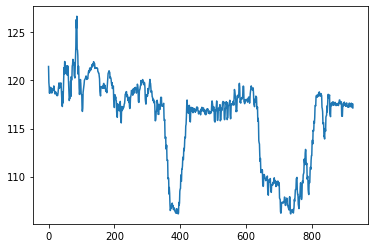

In [151]:
plt.plot(hepsi)

In [152]:
#np.savetxt("at10.csv", hepsi, delimiter=',')

In [153]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [154]:
def power_spectrum(mean_list, fps, hz_bottom, hz_top):
    sampling_rate = fps
    raw_signal = np.squeeze(mean_list) 
    normalized_signal = raw_signal - np.mean(raw_signal)
    normalized_signal = normalized_signal / np.std(normalized_signal)
    med_signal = medfilt(normalized_signal, 5)
    nyq = 0.5 * sampling_rate
    low = hz_bottom / nyq
    high = hz_top / nyq

    b, a = butter(3, [low, high], btype = 'band')
    filtered_signal = lfilter(b, a, med_signal)
    window = np.hamming(len(filtered_signal))
    windowed_signal = filtered_signal * window
    def nextpow(x):
        return 2 ** math.ceil(math.log2(x))

    NFFT = nextpow(len(windowed_signal) * sampling_rate)
    freqDomain = np.fft.fft(windowed_signal, NFFT)
    conj = np.conjugate(freqDomain)

    powerSpectrum = np.multiply(freqDomain, conj) / NFFT
    powerSpectrum = np.real(powerSpectrum)
    return powerSpectrum

In [155]:
def pre_train(array):
    snr = signaltonoise(array)
    std = np.std(array)
    ps = power_spectrum(array, fps, 1.0, 2.75)
    powerSNR = signaltonoise(ps)
    powerSTD = np.std(ps)
    dx = np.diff(array)
    dxSNR = signaltonoise(dx)
    dxSTD = np.std(dx)
     
    return {"name" : name,
            "SNR" : float(snr), 
            "STD" : std, 
            "powerSNR" : float(powerSNR), 
            "powerSTD" : powerSTD, 
            "dxSNR" : float(dxSNR), 
            "dxSTD" : dxSTD,
            "isReal" : 1}


In [156]:
new_row = pre_train(array=hepsi)

In [157]:
new_row

{'name': 'Esra_11',
 'SNR': 26.7299084306514,
 'STD': 4.339825268459249,
 'powerSNR': 0.2868328457997303,
 'powerSTD': 0.00034806785933530975,
 'dxSNR': -0.008138312610790783,
 'dxSTD': 0.5703995953122725,
 'isReal': 1}

In [158]:
df = df.append(new_row, ignore_index=True)
df

C:\Users\ahmet\AppData\Local\Temp\ipykernel_14944\1728607618.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


,name,SNR,STD,powerSNR,powerSTD,dxSNR,dxSTD,isReal
0,Esra_1,24.505708,6.292199,0.250347,0.00201,-0.01927,0.60668,1
1,Esra_2,30.506503,4.687045,0.2395,0.000121,0.033542,0.341471,1
2,Esra_3,84.422152,1.683961,0.239083,0.001457,-0.00224,0.366607,1
3,Esra_4,96.453915,1.408518,0.243875,0.002095,-0.012803,0.343105,1
4,Esra_5,58.850559,2.350135,0.224527,0.000526,-0.011331,0.306056,1
5,Esra_6,127.321246,1.099448,0.265267,0.002148,-0.009184,0.309139,1
6,Esra_7,95.865,1.506816,0.257095,0.00055,-0.028334,0.267591,1
7,Esra_8,97.236704,1.464426,0.24036,0.001375,-0.018673,0.259286,1
8,Esra_9,102.787606,1.569953,0.242229,0.001603,0.001045,0.431196,1
9,Esra_10,98.181252,1.35396,0.259275,0.001051,-0.019801,0.274047,1


In [159]:
df.to_csv('esra.csv', index=False)